In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, find_peaks
import os


In [ ]:
# change to your working directory
os.chdir(r'C:\Users\klilasulin\Dropbox\brain on a chip\Human brain organoids article\EMChip_paper_analysis_git')
os.getcwd()
#


'C:\\Users\\klilasulin\\Dropbox\\brain on a chip\\Human brain organoids article\\EMChip_paper_analysis_git'

In [39]:
# ------ Hyperparameters ------ #
sampling_rate = 200 # in Hz

min_overlap_val = 0.2

quiet_val_lfp = 0.2
peak_window_val_lfp =0.8

quiet_val_o2 = 0.4
peak_window_val_o2 =0.6




th_factor_lfp = 2.5
th_factor_o2 = 1.5

section_dur = 10 # seconds


In [ ]:
# load example data
exp_dict = {'LFP_baseline': {'start_sec': 110 , 'stop_sec': 130, 'file_path': 'data/Raw_LFP_signals_example/baseline1_OpenBCI-RAW-2025-01-05_17-16-53.txt'},
            'LFP_TTX':{'start_sec': 27 , 'stop_sec': 47, 'file_path': 'data/Raw_LFP_signals_example/ttx2_OpenBCI-RAW-2025-01-05_18-14-31.txt'} ,
            'O2_baseline': {'start_sec': 110 , 'stop_sec': 130, 'file_path': 'data/Raw_O2_signals_example/baseline1.txt'},
            'O2_TTX': {'start_sec': 27 , 'stop_sec': 47, 'file_path': 'data/Raw_O2_signals_example/ttx2.txt'}}

In [5]:

def create_lfp_df(file_name: str, sampling_rate: int, chan: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads a CSV file, keeps only 'time' and the specified 'chan' columns,
    and splits the result into 5-minute chunks based on the time column.

    :param file_name: Path to the CSV file.
    :param sampling_rate: Number of samples per second (used only to create the 'time' column
                          if the file does not already contain one).
    :param chan: The channel/column to keep in addition to 'time'.
    :return: A list of DataFrames, each corresponding to a 5-minute segment (300 seconds).
    """

    # Read the CSV file
    df = pd.read_csv(
        file_name,
        header=4,      # adjust if needed
        sep=', ',
        on_bad_lines='skip',
        engine='python'
    )

    # Create 'time' column using DataFrame index / sampling_rate (if needed)
    # If your CSV already has a 'time' column in seconds, you could skip this step
    row_indexes = np.array(df.index.tolist())
    df['time'] = row_indexes / sampling_rate

    # Keep only 'time' and the specified channel
    df = df[['time', chan]]

    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec
    df.rename(columns={chan: 'data'}, inplace=True)



   

    return df





def create_o2_df(file_path: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads an O2 data file and returns a DataFrame with 'time' and 'o2' columns.
    Skips the first 6 metadata lines.
    Assumes each subsequent line has two tab-separated columns: time_in_seconds and o2_value.
    """
    time_data = []
    o2_data = []

    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        lines = f.readlines()

    # Skip metadata lines (the snippet shows ignoring the first 6 lines)
    for i in range(6, len(lines)):
        fields = lines[i].strip().split('\t')
        if len(fields) < 2:
            continue
        try:
            t = float(fields[0])
            o2_val = float(fields[1])
            time_data.append(t)
            o2_data.append(o2_val)
        except ValueError:
            continue

    df = pd.DataFrame({'time': time_data, 'data': o2_data})
    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec


    return df


In [7]:
for exp_name, params in exp_dict.items():
    if 'LFP' in exp_name:
        file_path = params['file_path']
        lfp_df = create_lfp_df(file_path, sampling_rate, 'EXG Channel 0', params['start_sec'], params['stop_sec'])
        # add lfp_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = lfp_df
        
    elif 'O2' in exp_name:
        file_path = params['file_path']
        o2_df = create_o2_df(file_path, params['start_sec'], params['stop_sec'])
        # add o2_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = o2_df



In [8]:

# ---------------------
# Helper Functions
# ---------------------

def detect_bursts(peak_times, window=2.0, quiet=0.5, signal_start=0, signal_end=0):
    """
    Group detected peak times into bursts if consecutive peaks occur within 'window' seconds.
    A burst is accepted only if there is at least 'quiet' seconds with no peaks before and after.
    """
    if len(peak_times) == 0:
        return []

    groups = []
    current_group = [peak_times[0]]
    for t in peak_times[1:]:
        if t - current_group[-1] <= window:
            current_group.append(t)
        else:
            groups.append((current_group[0], current_group[-1]))
            current_group = [t]
    groups.append((current_group[0], current_group[-1]))

    valid_groups = []
    for i, (start, end) in enumerate(groups):
        if i == 0:
            prev_gap = start - signal_start
        else:
            prev_gap = start - groups[i-1][1]
        if i == len(groups)-1:
            next_gap = signal_end - end
        else:
            next_gap = groups[i+1][0] - end
        if prev_gap >= quiet and next_gap >= quiet:
            valid_groups.append((start, end))
    return valid_groups

def common_bursts(bursts1, bursts2, min_overlap=0.2):
    """
    Identify overlapping bursts between two sets.
    An overlap is accepted if the common interval is at least min_overlap seconds.
    """
    common = []
    for b1 in bursts1:
        for b2 in bursts2:
            overlap_start = max(b1[0], b2[0])
            overlap_end = min(b1[1], b2[1])
            if overlap_end - overlap_start >= min_overlap:
                common.append((overlap_start, overlap_end))
    return common


In [74]:

# ---------------------
# Main Detection Function
# ---------------------
def detect_common_events(lfp_df, o2_df,lfp_th, o2_th, dur, lfp_y_range, cond_name,
                         peak_window=2.0, quiet=0.5, min_overlap=0.2,peak_window_o2=2.0, quiet_o2=0.5):
    """
    Process two signals (each DataFrame must have 'time' and 'signal' columns).

    - The LFP signal is bandpass filtered between lowcut and highcut.
    - The O₂ signal is left unfiltered.
    - Peaks are detected with prominence thresholds (2×SD for LFP, 1×SD for O₂).
    - Peaks are grouped into bursts if consecutive peaks occur within peak_window seconds.
    - A burst is accepted only if it is flanked by at least quiet seconds of inactivity.
    - Common events are bursts overlapping by at least min_overlap seconds.

    Three separate plots are generated:
      1. LFP signal with detected peaks and bursts.
      2. O₂ signal with detected peaks and bursts.
      3. Common events: vertical dashed gray lines marking the burst start and end, with the area between filled in gray.

    Returns a dictionary containing detected peak times, bursts, and common events.
    """
    # --- Copy signals and extract time vectors ---
    time_lfp = lfp_df['time'].values.copy()
    lfp_signal = lfp_df['data'].values.copy()
    time_o2 = o2_df['time'].values.copy()
    o2_signal = o2_df['data'].values.copy()

    # reset time to start at 0
    time_lfp = time_lfp - time_lfp[0]
    time_o2 = time_o2 - time_o2[0]

    # crop to duration
    lfp_signal = lfp_signal[time_lfp <= dur]
    time_lfp = time_lfp[time_lfp <= dur]
    o2_signal = o2_signal[time_o2 <= dur]
    time_o2 = time_o2[time_o2 <= dur]

    # Estimate sampling rates
    fs_lfp = 1 / np.mean(np.diff(time_lfp))
    fs_o2 = 1 / np.mean(np.diff(time_o2))
    # print(f"LFP sampling rate: {fs_lfp} Hz")
    # print(f"O₂ sampling rate: {fs_o2} Hz")
    # --- Filter only LFP ---
    lfp_filtered = lfp_signal.copy()
    o2_filtered = o2_signal.copy()  # do not filter O₂

    # --- Peak Detection ---
    std_lfp = np.std(lfp_filtered)
    std_o2 = np.std(o2_filtered)

    peaks_lfp, _ = find_peaks(lfp_filtered, prominence=lfp_th)
    peaks_o2, _ = find_peaks(o2_filtered, prominence=o2_th)

    peak_times_lfp = time_lfp[peaks_lfp]
    peak_times_o2 = time_o2[peaks_o2]

    # --- Burst Detection ---
    bursts_lfp = detect_bursts(peak_times_lfp, window=peak_window, quiet=quiet,
                               signal_start=time_lfp[0], signal_end=time_lfp[-1])
    bursts_o2 = detect_bursts(peak_times_o2, window=peak_window_o2, quiet=quiet_o2,
                              signal_start=time_o2[0], signal_end=time_o2[-1])

    # --- Identify Common Events ---
    common = common_bursts(bursts_lfp, bursts_o2, min_overlap=min_overlap)
   
    # Plot 1: LFP Signal with Peaks & Bursts
    plt.figure(figsize=(7,12))
    plt.title(cond_name, fontsize = 28)
    plt.subplot(3, 1, 1)

    # plt.plot(time_lfp, lfp_filtered, label='LFP Filtered', color='darkred')
    plt.plot(time_lfp, lfp_filtered, color='darkred')
    # plt.plot(peak_times_lfp, lfp_filtered[peaks_lfp], 'ro', label='Peaks')
    plt.plot(peak_times_lfp, lfp_filtered[peaks_lfp], 'ro')
    for burst in bursts_lfp:
        plt.axvspan(burst[0], burst[1], color='green', alpha=0.3)
   
    plt.ylim(-50,70)
    
    # plt.xticks([])
    plt.yticks(fontsize = 16)
    plt.ylabel('Voltage (µV)', fontsize = 24)

    # plt.show()

    # ---------------------
    # Plot 2: O₂ Signal with Peaks & Bursts
    plt.subplot(3, 1, 2)
    # plt.plot(time_o2, o2_filtered, label='O₂ Signal')
    plt.plot(time_o2, o2_filtered)
    # plt.plot(peak_times_o2, o2_filtered[peaks_o2], 'ro', label='Peaks')
    plt.plot(peak_times_o2, o2_filtered[peaks_o2], 'ro')
    for burst in bursts_o2:
        plt.axvspan(burst[0], burst[1], color='green', alpha=0.3)
    
    # dont plot x ticks
    # plt.xticks([])
    plt.ylim(10,70)
    plt.ylabel('Oxygen (%)', fontsize = 24)
    # plt.xlim(xlim_start, xlim_end)
    plt.yticks(fontsize = 16)
    plt.xlabel('Time (s)')



    # ---------------------
    # Plot 3: Common Events (Vertical Lines & Filled Region)
    plt.subplot(3, 1, 3)
    plt.plot(time_lfp, np.zeros_like(time_lfp), 'w-')

    # plt.axhline(0, color='white', alpha=0)

    total_common_bursts_len = 0
    for burst in common:
        total_common_bursts_len += burst[1] - burst[0]
        plt.axvline(burst[0], color='gray', linestyle='--', linewidth=1)
        plt.axvline(burst[1], color='gray', linestyle='--', linewidth=1)
        plt.fill_betweenx([-1, 1], burst[0], burst[1], color='gray', alpha=0.3)

    plt.yticks([])
    plt.xticks([], fontsize = 1)

    # THE FIX — force axes instead of letting matplotlib autoscale
    # plt.xlim(0, dur)
    plt.ylim(-1, 1)

    plt.show()

    print('Total Common Bursts Lentgh: ', total_common_bursts_len)
    return {
        'lfp_peaks': peak_times_lfp,
        'o2_peaks': peak_times_o2,
        'lfp_bursts': bursts_lfp,
        'o2_bursts': bursts_o2,
        'common_events': common,
        'total_common_bursts_len': total_common_bursts_len
    }



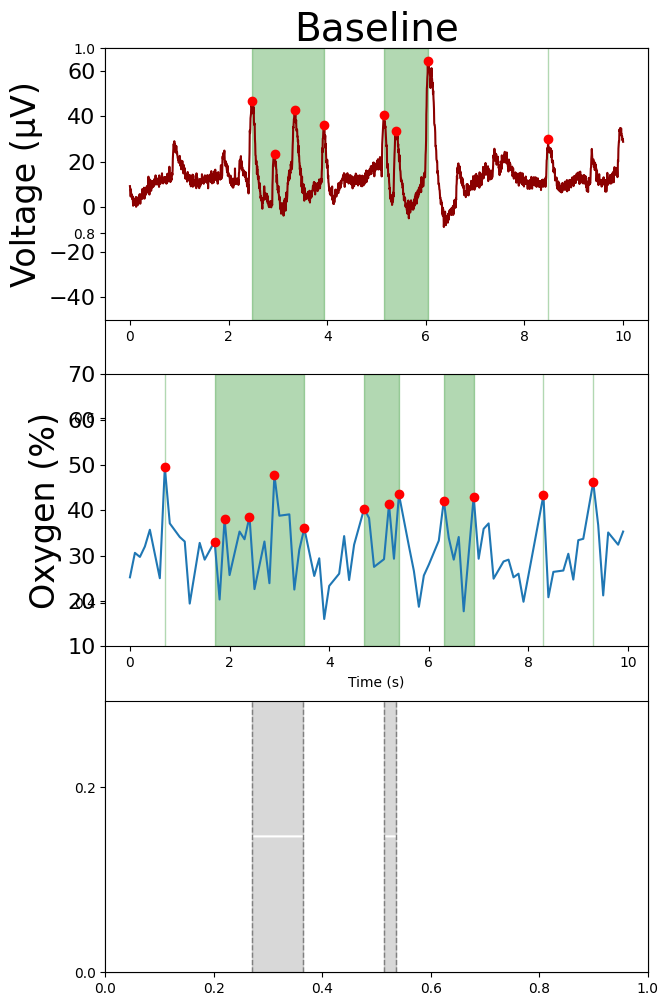

Total Common Bursts Lentgh:  1.2850000000000108


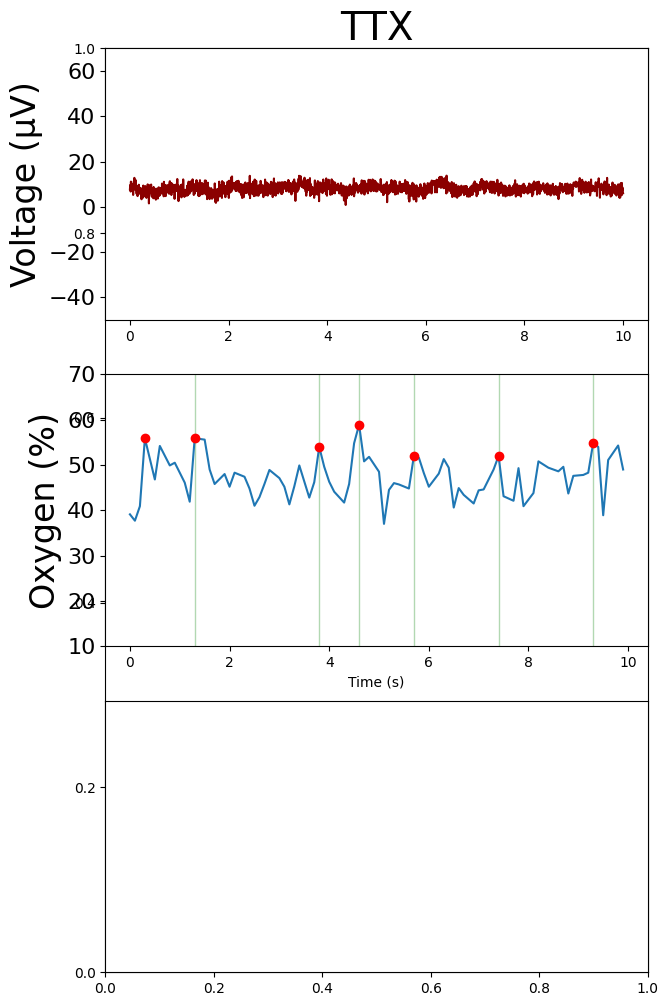

Total Common Bursts Lentgh:  0


In [75]:

lfp_th = np.std(exp_dict['LFP_baseline']['data_df']['data'].values) * th_factor_lfp
o2_th = np.std(exp_dict['O2_baseline']['data_df']['data'].values) *th_factor_o2



results_df_baseline = detect_common_events(exp_dict['LFP_baseline']['data_df'], exp_dict['O2_baseline']['data_df'],lfp_th, o2_th, section_dur , (-(lfp_th)*5,(lfp_th)*5 ), 'Baseline', peak_window=peak_window_val_lfp, quiet=quiet_val_lfp, min_overlap=min_overlap_val,peak_window_o2=peak_window_val_o2, quiet_o2=quiet_val_o2)
results_df_ttx = detect_common_events(exp_dict['LFP_TTX']['data_df'], exp_dict['O2_TTX']['data_df'],lfp_th, o2_th, section_dur, (-(lfp_th)*5,(lfp_th)*5 ), 'TTX', peak_window=peak_window_val_lfp, quiet=quiet_val_lfp, min_overlap=min_overlap_val,peak_window_o2=peak_window_val_o2, quiet_o2=quiet_val_o2)


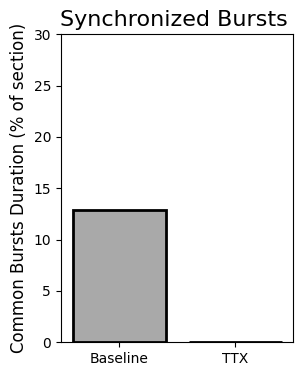

In [78]:
x_data = ['Baseline', 'TTX']
y_data = [results_df_baseline['total_common_bursts_len'], results_df_ttx['total_common_bursts_len']]
y_data_percent = [results_df_baseline['total_common_bursts_len']/section_dur*100, results_df_ttx['total_common_bursts_len']/section_dur*100]

plt.figure(figsize=(3,4))
sns.barplot(x=x_data, y=y_data_percent, color='darkgray', edgecolor='black', linewidth=2)
plt.ylabel('Common Bursts Duration (% of section)', fontsize=12)
plt.title('Synchronized Bursts ', fontsize=16)
plt.ylim(0,30)
plt.show()

